# Plot Einstein Telescope alignment sensing noise and make bode plots

Authors: Conor Mow-Lowry <c.m.mow-lowry@vuDOTnl> (original), Octavio Vega <vega00087@gmailDOTcom> (adapted for Spicypy)

 If not done already, install spicypy (uncomment the line below):

In [1]:
 #pip install spicypy

Note: on Windows the above might not work, you may see a compilation error in `ligo-segments` package. If this happens, please install `gwpy` separately first, by running `conda install -c conda-forge gwpy` in your terminal. (It must be an Anaconda environment, unfortunately currently there's no easy way to install on Windows without Anaconda. We are working on that)

In [2]:
import numpy as np

from control import tf, tf2ss, ss2tf, StateSpace, step_response, bode_plot, freqresp
from control.matlab import zpk2tf
from spicypy.control.system import System

import matplotlib as mpl
import matplotlib.pyplot as plt

import os

Define helper functions:

Get corresponding roots (zeroes OR poles) corresponding to a resonant frequency and quality factor

In [3]:
def pairQ(f0, Q):
    '''
    inputs: f0 (resonant frequency), Q (quality factor)
    outputs: r (corresponding pair of roots, zeros or poles)
    '''
    
    Q += 0j
    
    # resonant freq in rads/sec
    r0 = 2*np.pi*f0
    
    res = np.sqrt(1-4*Q**2)
    mag = r0/(2*Q)

    r1 = mag*(1 + res)/(2*np.pi)
    r2 = mag*(1 - res)/(2*np.pi)
    
    return [r1, r2]

Generate Virgo style zpk system:

In [4]:
def zpkgf(zeroes, poles, gain, gfreq):
    '''
    funct to generate Virgo-style zpk system
    inputs: zeroes (vector of zeroes in Hz), poles (vector of poles in Hz), 
            gain (desired gain at f = gfreq), gfreq (frequency of desired gain)
    '''
    # recast to numpy arrays
    zeroes = np.array(zeroes)
    poles = np.array(poles)
    
    pp = -2*np.pi*poles
    zz = -2*np.pi*zeroes
    
    sys = tf(*zpk2tf(zz, pp, 1))
    gain_init, phase_init, omega_init = freqresp(sys, 2*np.pi*gfreq)
    kk = gain/np.abs(gain_init)
    
    return tf(*zpk2tf(zz, pp, kk))

### Import ET design sensitivity curve

In [5]:
# create logspace 10**-2 to 10**1
f = np.logspace(-2, 1, 1000)

In [6]:
# read in the file
path = 'ET_sensitivity_data/ET_0000A_18_ETDSensitivityCurve.txt'
file = open(path,"r")

# lists to store column data
col1 = []
col2 = []
col3 = []
col4 = []

# read each line and get data
lines = file.readlines()
for line in lines:
    col1.append(float(line.split()[0]))
    col2.append(float(line.split()[1]))
    col3.append(float(line.split()[2]))
    col4.append(float(line.split()[3]))
file.close()

In [7]:
# relabel and transform columns
fEt = np.array(col1)
xEtLf = np.array(col2)*10.**4
xEtHf = np.array(col3)*10.**4
xEtD = np.array(col4)*10.**4

Assumptions for some parameters

In [8]:
# Spot mis-centering, assuming Virgo/LIGO-like 1mm [m]
d = 1e-3 

# Wavefront-sensor shot-noise. Assuming Virgo/LIGO like, but pessimistic 
# due to wavelength and power. 
n = 1e-14;  # radians/sqrt(Hz)

## Define Plant and Controller

In [9]:
# For plant, want to assume a pole at 60mHz, Virgo-like, but stiffened to 
# 250mHz by Sigg-Sidles second pole at differential mode, assuming 
# 'irrelevantly high' at ~10 Hz.
p = System(zpkgf([], pairQ(250e-3,100) + pairQ(10,100), 1e-1, 1))

C:\Users\Arbasa\miniforge3\envs\gwpy\Lib\site-packages\control\lti.py:524: FutureWarning: freqresp() is deprecated; use frequency_response()
  warn("freqresp() is deprecated; use frequency_response()", FutureWarning)
C:\Users\Arbasa\miniforge3\envs\gwpy\Lib\site-packages\control\statesp.py:1670: FutureWarning: ss2io() is deprecated; use ss()
  warn("ss2io() is deprecated; use ss()", FutureWarning)


In [10]:
# zeroes, poles, gain of p
print('Zeroes of p: ' + str(p.zeros()))
print('Poles of p: ' + str(p.poles()))

Zeroes of p: []
Poles of p: [-0.31415927+62.83106767j -0.31415927-62.83106767j
 -0.00785398 +1.57077669j -0.00785398 -1.57077669j]


In [11]:
# Controller should have UGF >250mHz and noise less than ET-D at 3 Hz.
# Will use several cut-off sections
cut1 = System(zpkgf(pairQ(5,2), [1.2, 1.5], 1, 0))
cut2 = System(zpkgf(pairQ(10,1000) + pairQ(10,5), pairQ(10,10) + pairQ(5,1), 1, 0))
cont1 = System(zpkgf([0.1,0.1], [0.03] + pairQ(3,0.7), 1, 0.3))

c = cont1*cut1*cut2

In [12]:
# zeroes, poles, gain of c
print('Zeroes of c: ' + str(c.zeros()))
print('Poles of c: ' + str(c.poles()))

Zeroes of c: [-6.2831855 +62.51690415j -6.2831855 -62.51690415j
 -0.03141601+62.83184445j -0.03141601-62.83184445j
 -7.85398163+30.41834007j -7.85398163-30.41834007j
 -0.62834212 +0.j         -0.62829495 +0.j        ]
Poles of c: [ -3.14159265+62.75326411j  -3.14159265-62.75326411j
 -15.70796327+27.20699046j -15.70796327-27.20699046j
 -13.46396852+13.19194111j -13.46396852-13.19194111j
  -9.42477796 +0.j          -7.53982237 +0.j
  -0.18849556 +0.j        ]


## Calculate open-loop gain:

In [13]:
olg = c*p
#olgFr = abs(evalfr(olg, f))
olgFr, olg_phase, olg_omega = freqresp(olg,2*np.pi*f)

In [14]:
# zeroes, poles, gain of olg
print('Zeroes of olg: ' + str(olg.zeros()))
print('Poles of olg: ' + str(olg.poles()))

Zeroes of olg: [-3.43578267e+18 +0.j         -3.14158022e-02+62.83184533j
 -3.14158022e-02-62.83184533j -6.28318543e+00+62.51690433j
 -6.28318543e+00-62.51690433j -7.85398163e+00+30.41834007j
 -7.85398163e+00-30.41834007j -6.28318642e-01 +0.j
 -6.28318419e-01 +0.j        ]
Poles of olg: [-3.14159265e-01+62.83106767j -3.14159265e-01-62.83106767j
 -3.14159265e+00+62.75326411j -3.14159265e+00-62.75326411j
 -1.57079633e+01+27.20699046j -1.57079633e+01-27.20699046j
 -1.34639685e+01+13.19194111j -1.34639685e+01-13.19194111j
 -9.42477796e+00 +0.j         -7.53982237e+00 +0.j
 -7.85398163e-03 +1.57077669j -7.85398163e-03 -1.57077669j
 -1.88495559e-01 +0.j        ]


In [15]:
ascN = olgFr*d*n
ascEtd = np.interp(fEt, f, ascN) 

In [16]:
etAsc = np.sqrt(ascEtd**2 + xEtD**2)

## Plot ACS noise spectrum compared to ET design sensitivity

In [17]:
os.getcwd()
dir_plot = os.getcwd() + '\\plots'

In [18]:
# plotting parameters
plt.rcParams['figure.dpi'] = 300

Produce step response plot

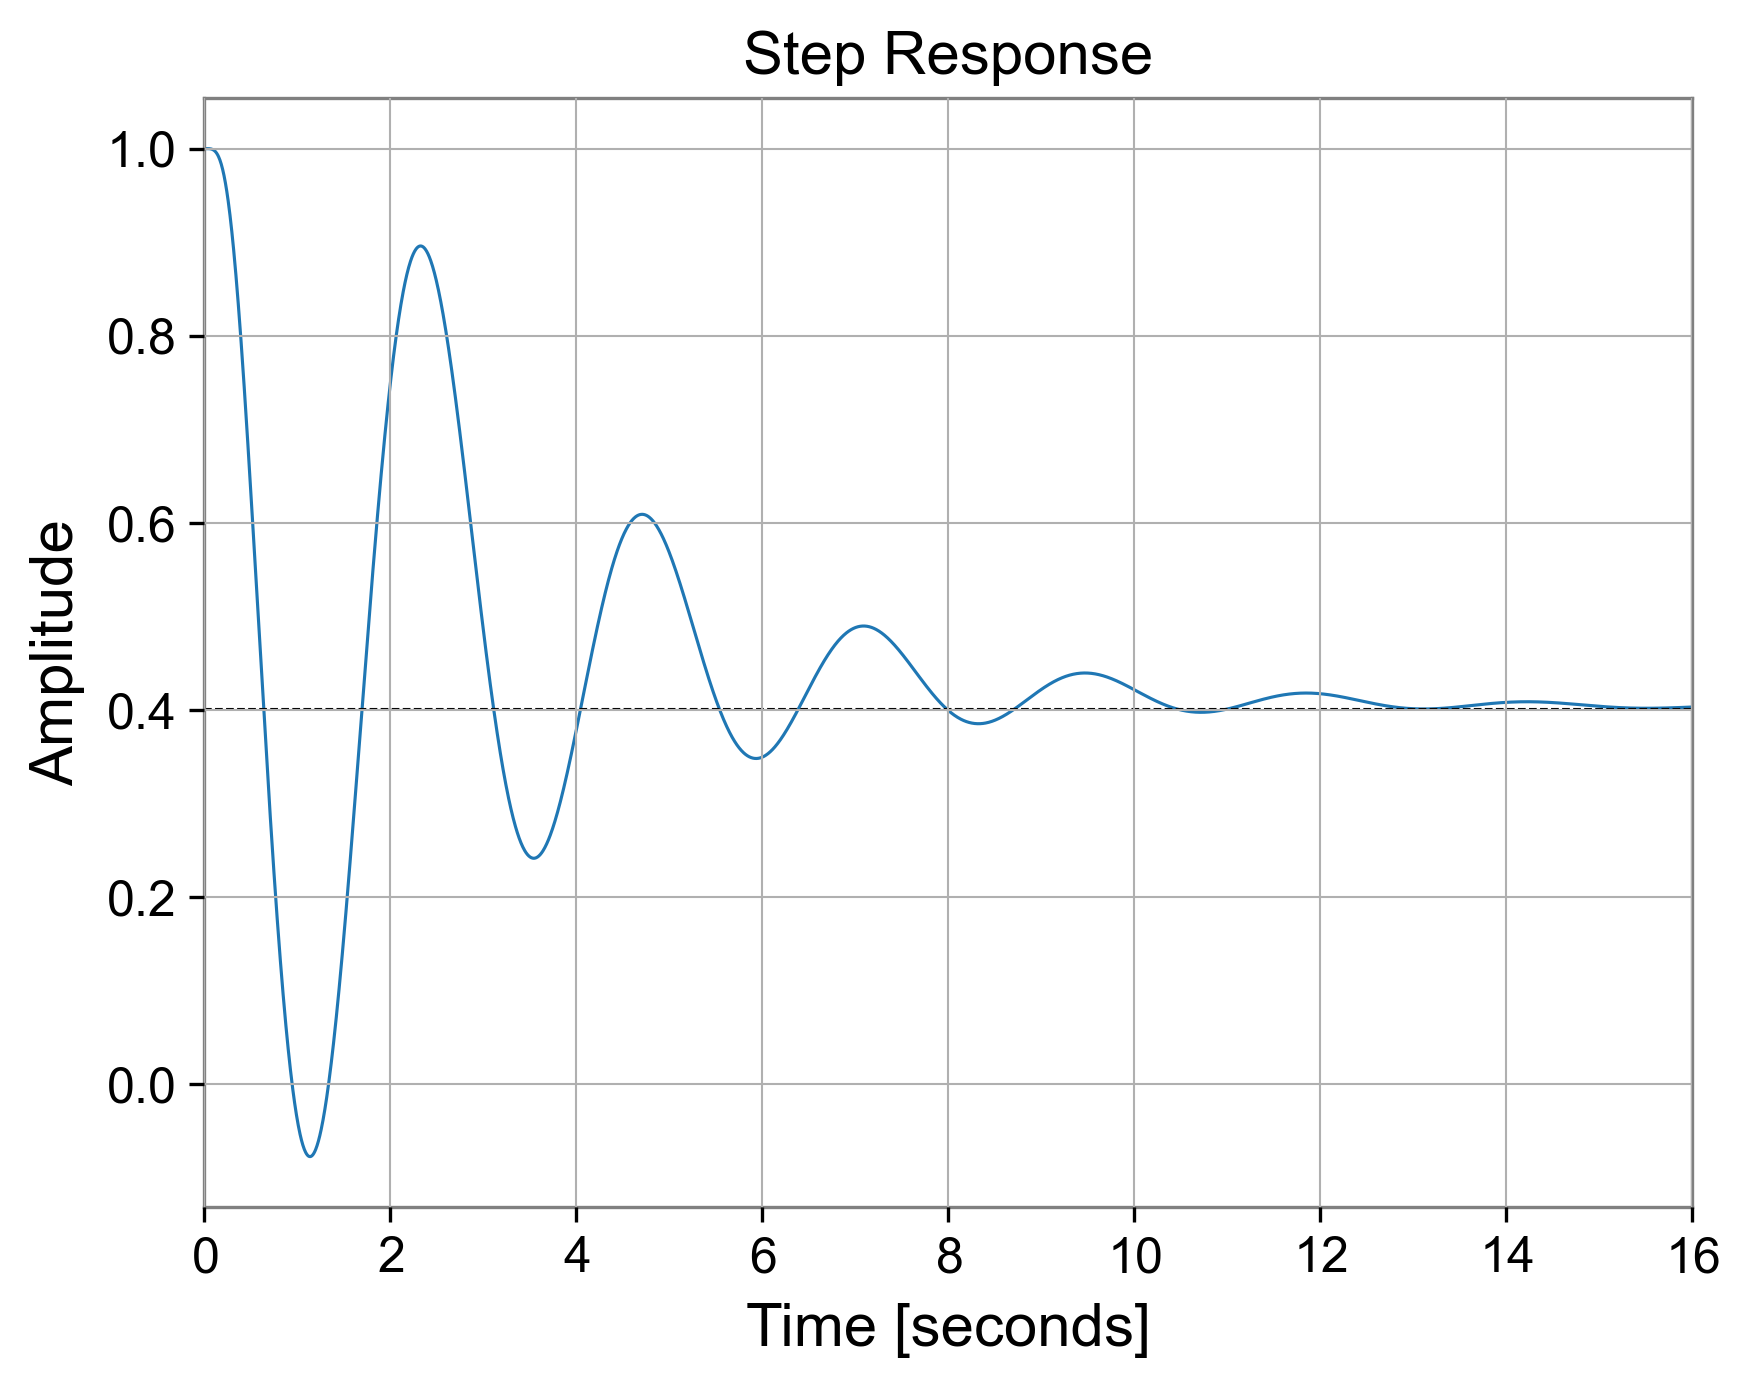

In [19]:
plt.plot(step_response(1/(1+ss2tf(olg)))[0], step_response(1/(1+ss2tf(olg)))[1], lw=0.75)
plt.xlabel('Time [seconds]')
plt.ylabel('Amplitude')
plt.axhline(y=0.40134, color='black', linestyle='--', lw=0.5)
plt.xlim(0,16)
plt.title('Step Response')

save = False
if save:
    plt.savefig(dir_plot + '\\olg_step_resp.pdf', dpi=300)

Einstein Telescope design sensitivity curve superimposed with ASC noise

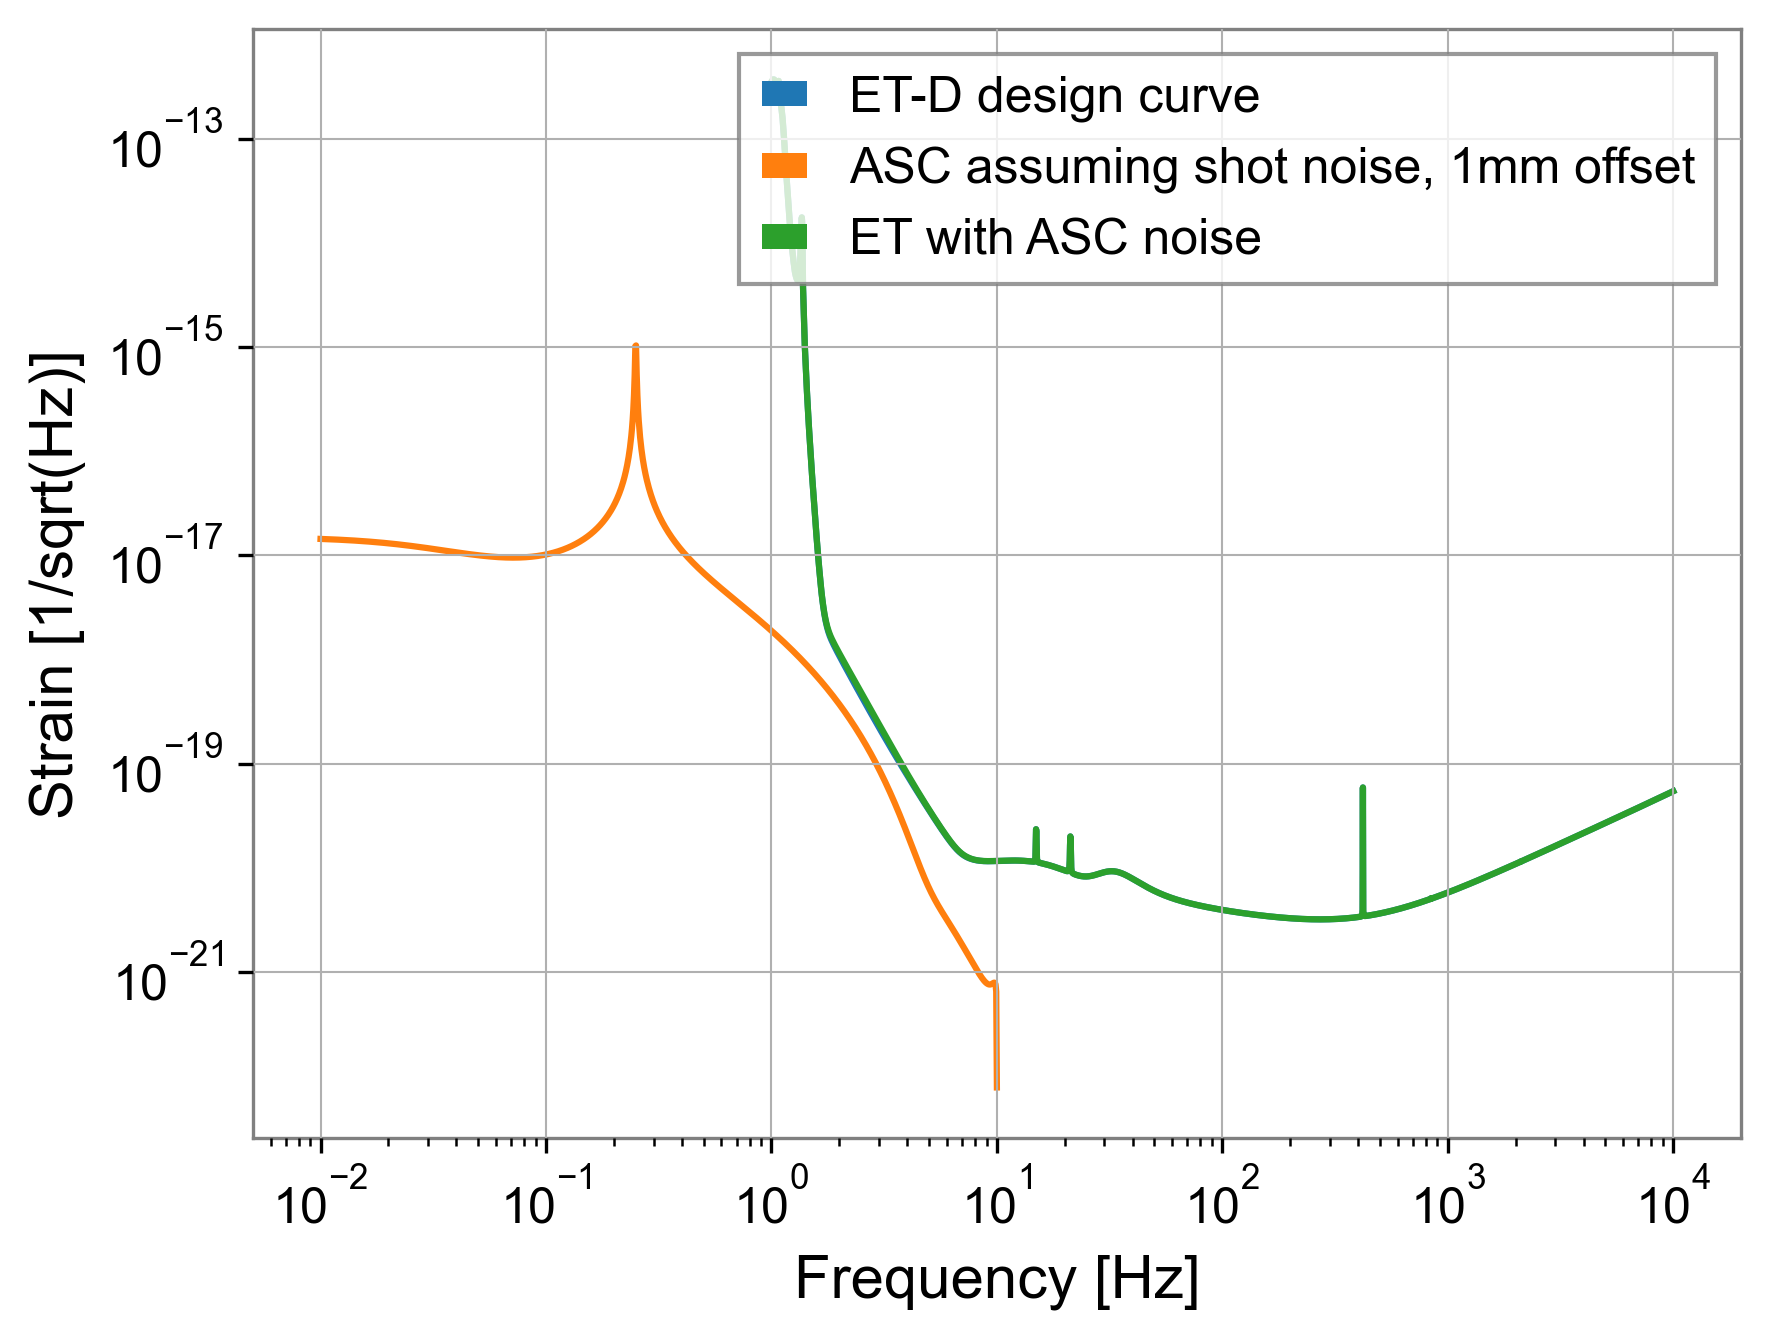

In [20]:
# full window
plt.plot(fEt, xEtD, label='ET-D design curve')
plt.plot(f, ascN, label='ASC assuming shot noise, 1mm offset')
plt.plot(fEt, etAsc, label='ET with ASC noise')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain [1/sqrt(Hz)]')
plt.legend()

save = False
if save:
    plt.savefig(dir_plot + '\\curves_superimposed.pdf', dpi=300)

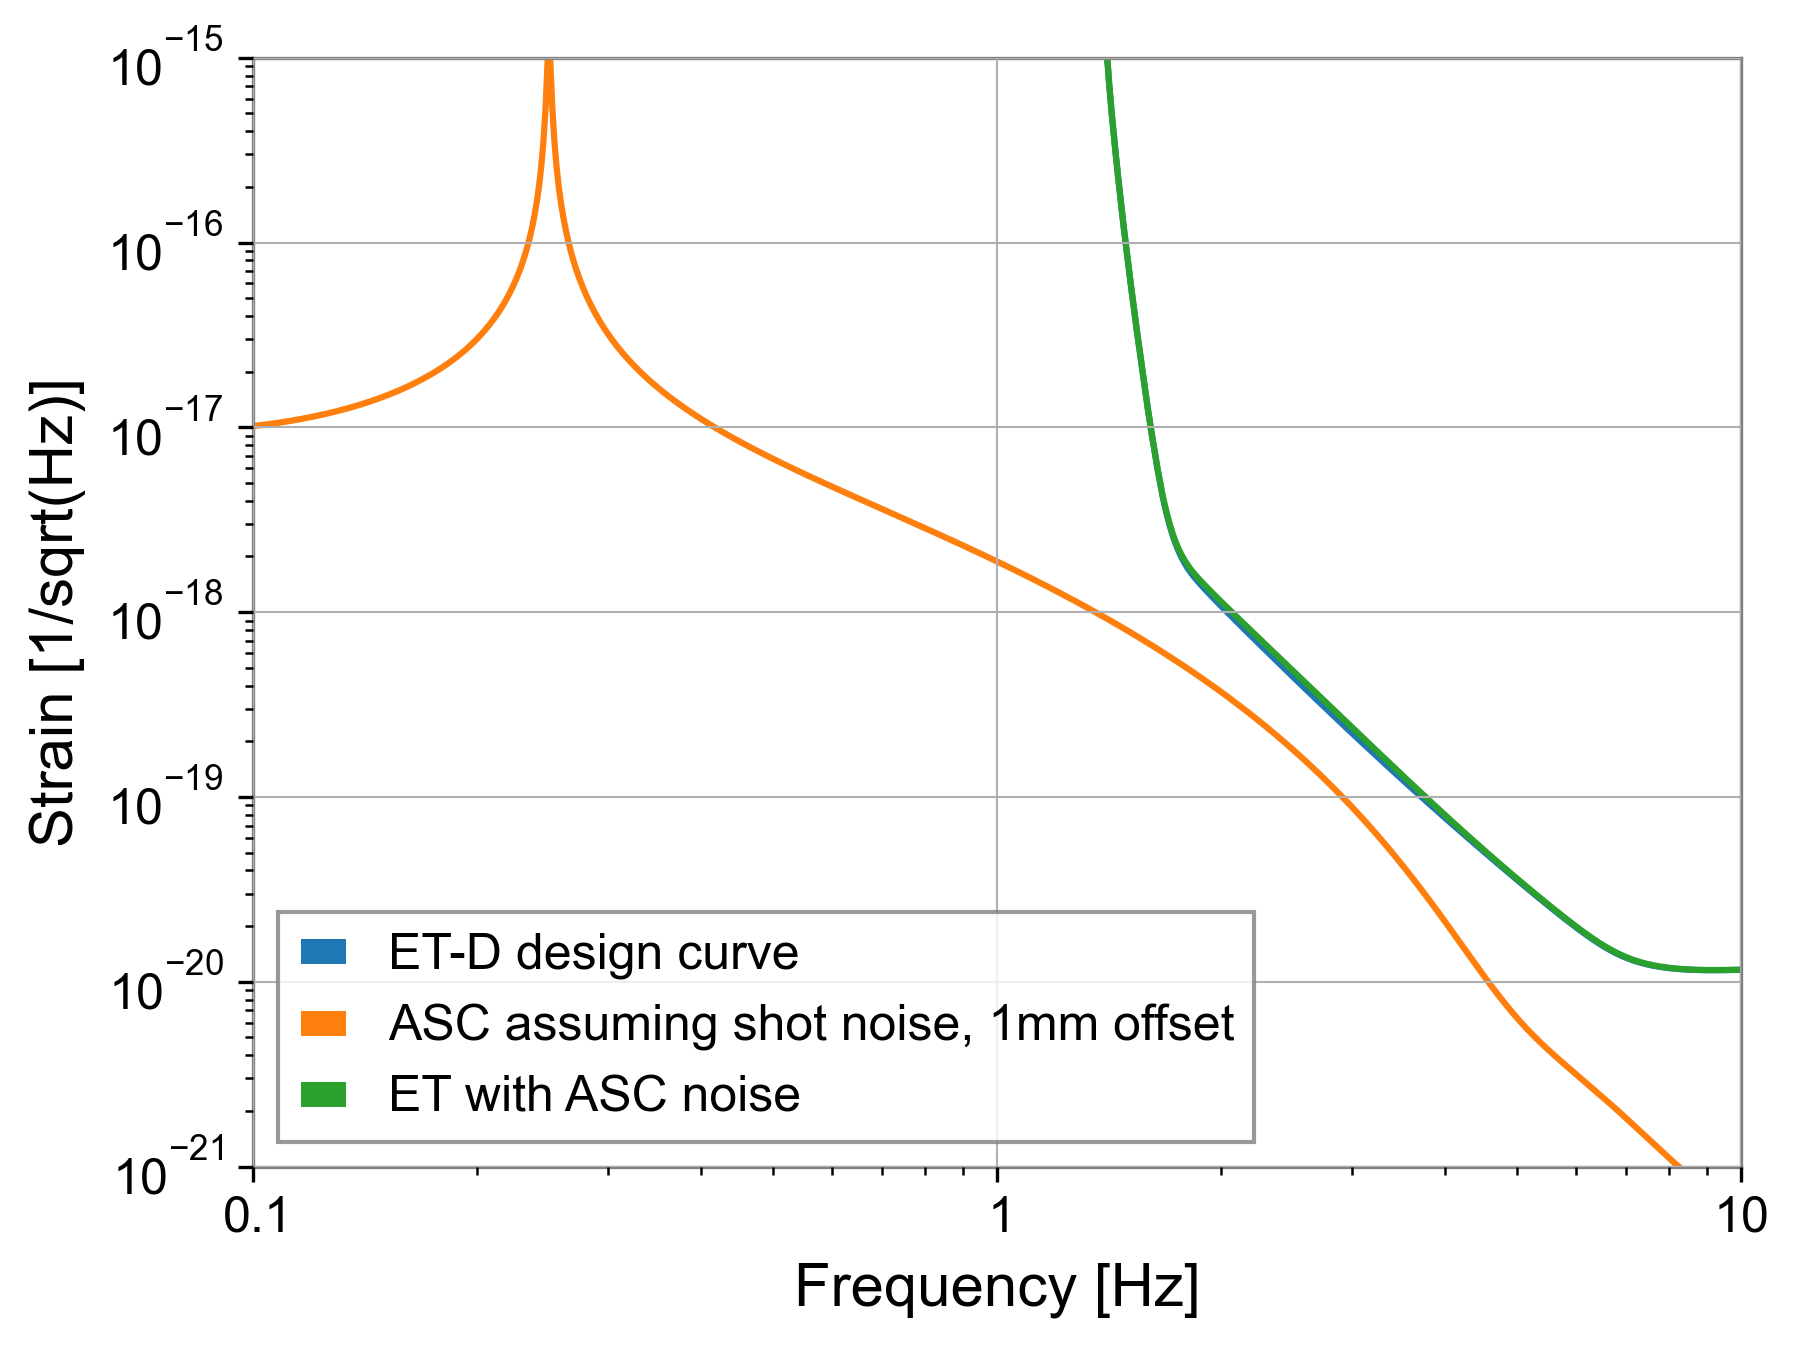

In [21]:
# with the same MATLAB xlimits
plt.plot(fEt, xEtD, label='ET-D design curve')
plt.plot(f, ascN, label='ASC assuming shot noise, 1mm offset')
plt.plot(fEt, etAsc, label='ET with ASC noise')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(10**-1, 10**1)
plt.ylim(10**-21, 10**-15)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Strain [1/sqrt(Hz)]')

save = False
if save:
    plt.savefig(dir_plot + '\\curves_superimposed_zoomed.pdf', dpi=300)

Bode plots

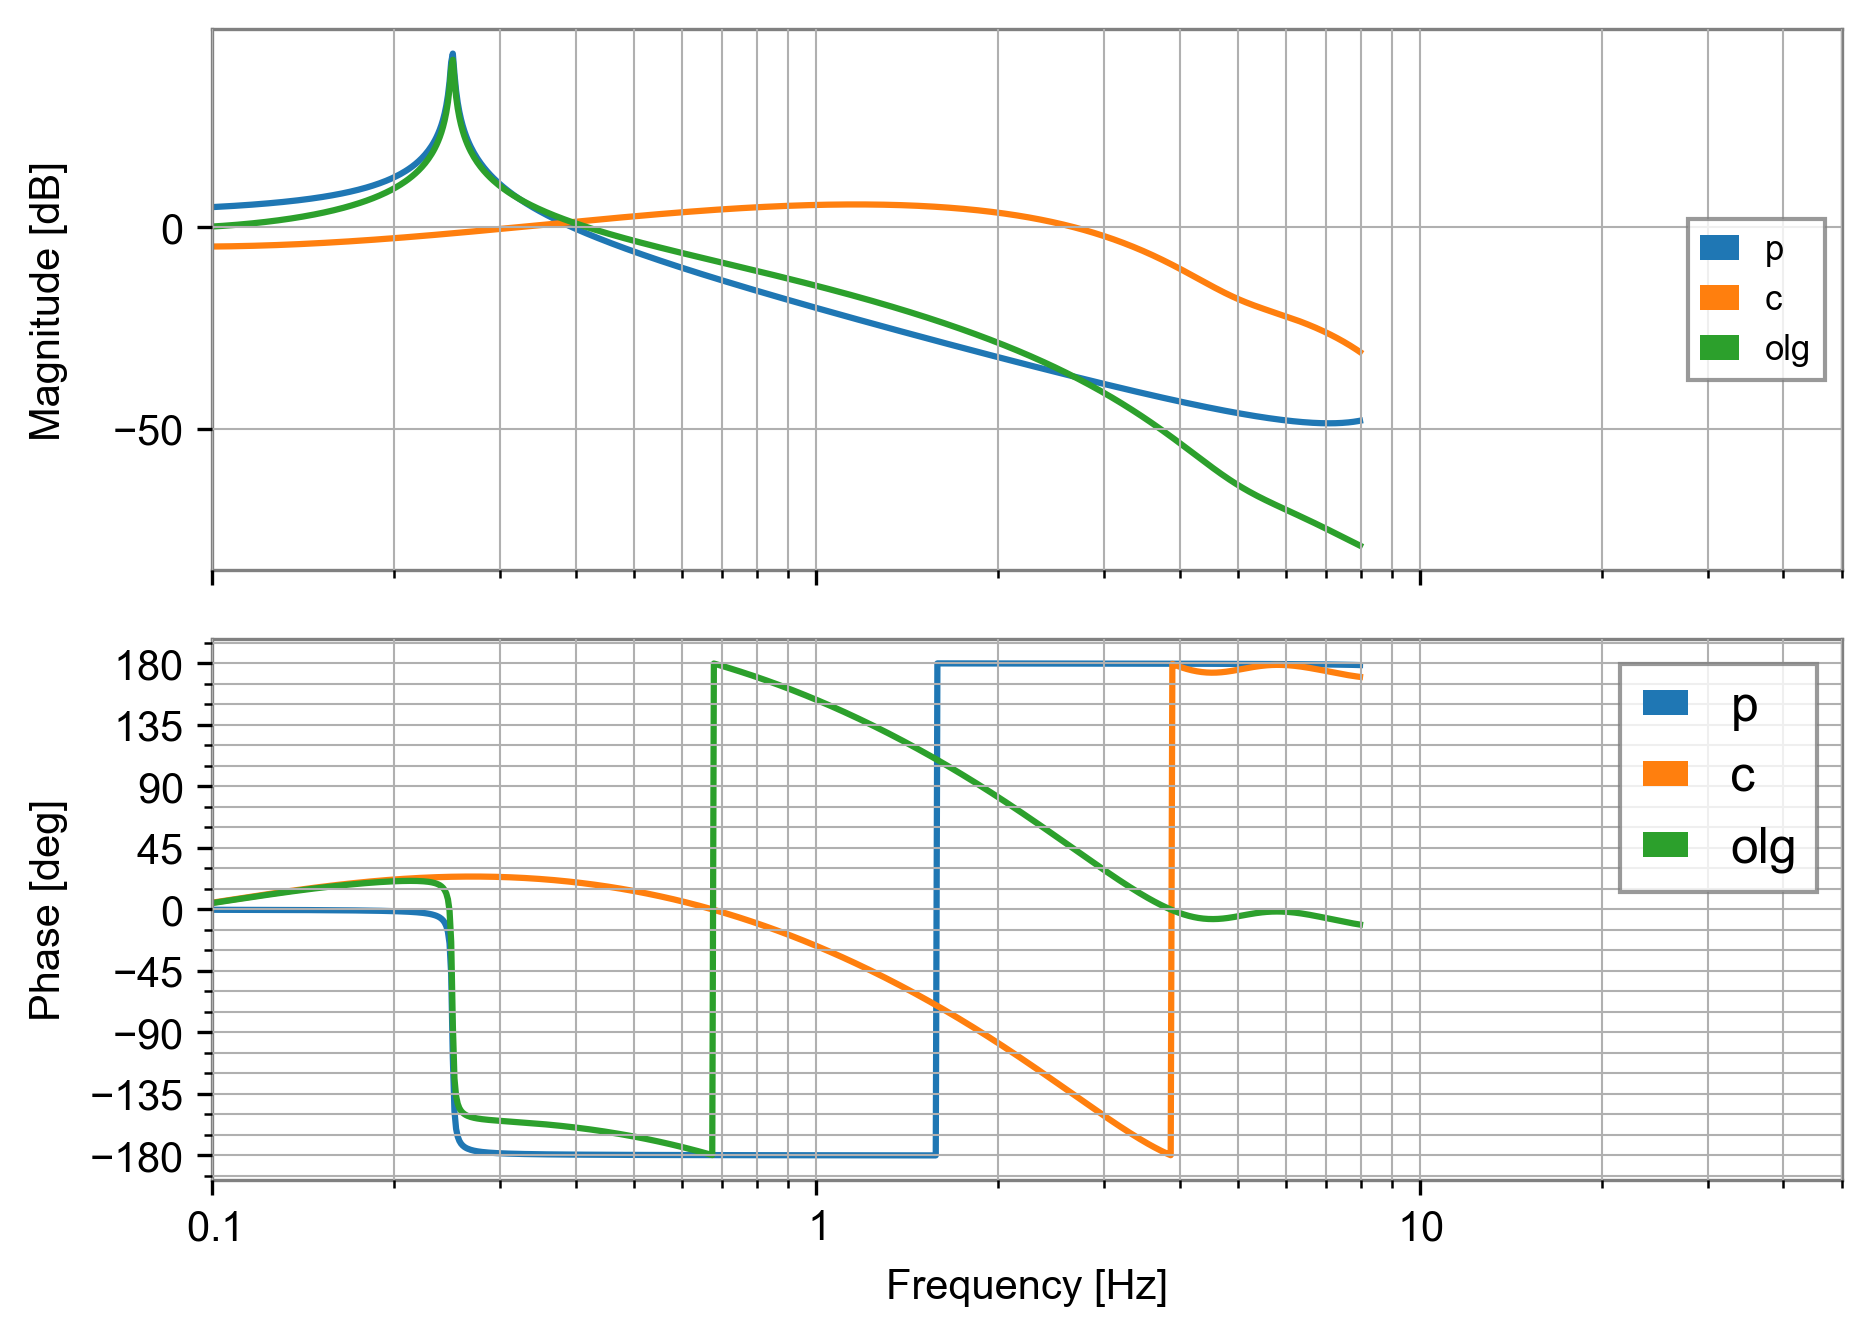

In [23]:
bode_plot(p, Hz=True, deg=True, wrap_phase=True, omega_limits=(0.1,50), 
                                 label='p')
bode_plot(c, Hz=True, deg=True, wrap_phase=True, omega_limits=(0.1,50), 
                                 label='c')
bode_plot(olg, Hz=True, deg=True, wrap_phase=True, omega_limits=(0.1,50), 
                                 label='olg')
fig = plt.gcf()
plt.legend()

save = False
if save:
    plt.savefig(dir_plot + '\\bode_plots.pdf', dpi=300)